In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import json
import os
import re
from copy import deepcopy
import sys
from typing import List, Dict, Tuple, Union, Optional, Any
import torch
from collections import defaultdict
from IPython.display import display

mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.size"] = 12

DATASET_NAMES = [
    "glue-cola",
    "glue-mnli",
    "glue-mrpc",
    "glue-qqp",
    "glue-rte",
    "glue-sst2",
    "glue-stsb",
]
MODEL_NAME = 'flan-t5-base'

In [2]:
def version_of_max_accuracy(
    model_name: str,
    single_task_data: pd.DataFrame,
    dataset_name: str,
    method: str,
) -> str:
    """
    Given a model name, a dataset name, and a DataFrame containing single task data,
    returns the version of the model with the highest accuracy on the given dataset.

    Args:
    - model_name (str): the name of the model to search for
    - single_task_data (pd.DataFrame): a DataFrame containing single task data
    - dataset_name (str): the name of the dataset to search for

    Returns:
    - version (str): the version of the model with the highest accuracy on the given dataset
    """

    seleted_rows = single_task_data[
        [
            all(b)
            for b in zip(
                single_task_data["model"] == model_name,
                single_task_data["dataset"] == dataset_name,
                single_task_data["method"] == method,
            )
        ]
    ]
    max_row = seleted_rows.loc[seleted_rows["accuracy"].idxmax()]
    version = max_row["version"]
    return version

def zero_if_nan(x):
    if np.isnan(x):
        return 0
    else:
        return x

In [3]:
single_task_data = pd.read_csv('single_task.csv')

fft_data = { num_tasks: pd.read_csv(f'fft_task_addition_num-tasks={num_tasks}.csv') for num_tasks in range(2, 8)}
lora_data = { num_tasks: pd.read_csv(f'lora_task_addition_num-tasks={num_tasks}.csv') for num_tasks in range(2, 8)}
l_lora_data = { num_tasks: pd.read_csv(f'l_lora_task_addition_num-tasks={num_tasks}.csv') for num_tasks in range(2, 8)}

Conver score to relative score

In [4]:
fft_max_score = {}
for dataset_name in DATASET_NAMES:
    version = version_of_max_accuracy(
        MODEL_NAME, single_task_data, dataset_name, method="fullfinetuned"
    )
    row = single_task_data[
        [
            all(b)
            for b in zip(
                single_task_data["version"] == version,
                single_task_data["dataset"] == dataset_name,
                single_task_data["method"] == 'fullfinetuned',
            )
        ]
    ]
    assert len(row) == 1
    fft_max_score[dataset_name] = row.iloc[0]["accuracy"]

for num_tasks in fft_data.keys():
    data = fft_data[num_tasks]
    for i in range(len(data)):
        for dataset_name in DATASET_NAMES:
            data.at[i, dataset_name] = zero_if_nan(data.at[i, dataset_name]) / fft_max_score[dataset_name]

In [5]:
lora_max_score = {}
for dataset_name in DATASET_NAMES:
    version = version_of_max_accuracy(
        MODEL_NAME, single_task_data, dataset_name, method="fullfinetuned"
    )
    row = single_task_data[
        [
            all(b)
            for b in zip(
                single_task_data["version"] == version,
                single_task_data["dataset"] == dataset_name,
                single_task_data["method"] == 'fullfinetuned',
            )
        ]
    ]
    assert len(row) == 1
    lora_max_score[dataset_name] = row.iloc[0]["accuracy"]

for num_tasks in fft_data.keys():
    data = lora_data[num_tasks]
    for i in range(len(data)):
        for dataset_name in DATASET_NAMES:
            data.at[i, dataset_name] = zero_if_nan(data.at[i, dataset_name]) / lora_max_score[dataset_name]

In [6]:
l_lora_max_score = {}
for dataset_name in DATASET_NAMES:
    version = version_of_max_accuracy(
        MODEL_NAME, single_task_data, dataset_name, method="fullfinetuned"
    )
    row = single_task_data[
        [
            all(b)
            for b in zip(
                single_task_data["version"] == version,
                single_task_data["dataset"] == dataset_name,
                single_task_data["method"] == 'fullfinetuned',
            )
        ]
    ]
    assert len(row) == 1
    l_lora_max_score[dataset_name] = row.iloc[0]["accuracy"]

for num_tasks in fft_data.keys():
    data = l_lora_data[num_tasks]
    for i in range(len(data)):
        for dataset_name in DATASET_NAMES:
            data.at[i, dataset_name] = zero_if_nan(data.at[i, dataset_name]) / l_lora_max_score[dataset_name]

plot

In [7]:
def get_row_mean(row, col_names: List[str] = [
    "glue-cola",
    "glue-mnli",
    "glue-mrpc",
    "glue-qqp",
    "glue-rte",
    "glue-sst2",
    "glue-stsb",
]):
    zero_if_nan = lambda x: 0 if np.isnan(x) else x
    s = 0
    for col in col_names:
        s += zero_if_nan(row[col])
    return s / len(col_names)

def get_max_row_mean(data):
    results = defaultdict(lambda: list())
    for num_tasks in data.keys():
        group = data[num_tasks].groupby([f'dataset:{i}' for i in range(num_tasks)])
        for g in group:
            tasks = g[0]
            max_mean = float('-inf')
            max_index = 0
            for i, row in g[1].iterrows():
                mean = get_row_mean(row)
                if mean > max_mean:
                    max_mean = mean
                    max_index = i
            row = deepcopy(data[num_tasks].iloc[max_index])
            row.loc['mean'] = max_mean
            results[num_tasks].append(row)
        results[num_tasks] = pd.DataFrame(results[num_tasks])
    return results

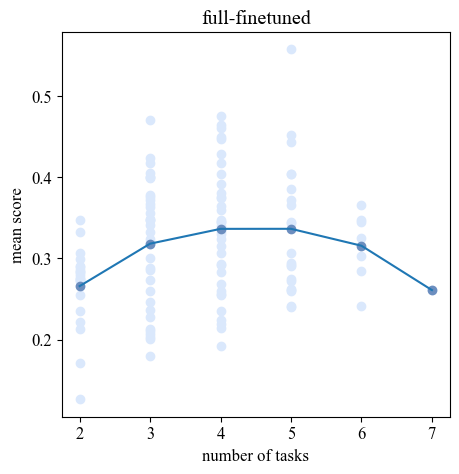

In [8]:
title = 'full-finetuned'
data = fft_data
# --------------
results = get_max_row_mean(data)
# for num_tasks in results:
#     print(num_tasks)
#     display(results[num_tasks])

fig, axes = plt.subplots(1,1,figsize=(5,5), squeeze=False)
ax: plt.Axes = axes[0,0]
Y_mean = []
for num_tasks in results:
    Y = np.array(results[num_tasks]['mean'])
    X = np.ones_like(Y) * num_tasks
    Y_mean.append(Y.mean())
    ax.scatter(X, Y, color = '#DAE8FC')
    ax.scatter([num_tasks], [Y.mean()], color = '#6C8EBF')
ax.plot(np.array(list(results.keys())), np.array(Y_mean))

ax.set_title(title)
ax.set_xlabel('number of tasks')
ax.set_ylabel('mean score')
plt.show()

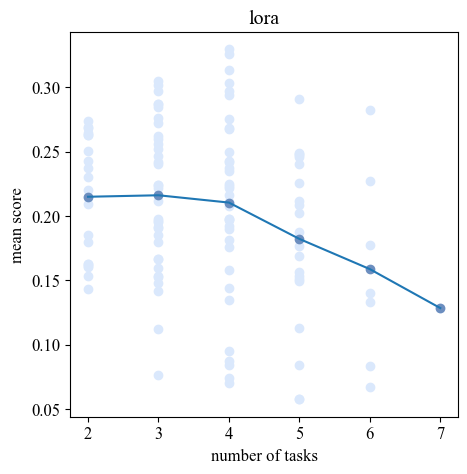

In [9]:
title = 'lora'
data = lora_data
# --------------
results = get_max_row_mean(data)
# for num_tasks in results:
#     print(num_tasks)
#     display(results[num_tasks])

fig, axes = plt.subplots(1,1,figsize=(5,5), squeeze=False)
ax: plt.Axes = axes[0,0]
Y_mean = []
for num_tasks in results:
    Y = np.array(results[num_tasks]['mean'])
    X = np.ones_like(Y) * num_tasks
    Y_mean.append(Y.mean())
    ax.scatter(X, Y, color = '#DAE8FC')
    ax.scatter([num_tasks], [Y.mean()], color = '#6C8EBF')
ax.plot(np.array(list(results.keys())), np.array(Y_mean))

ax.set_title(title)
ax.set_xlabel('number of tasks')
ax.set_ylabel('mean score')
plt.show()

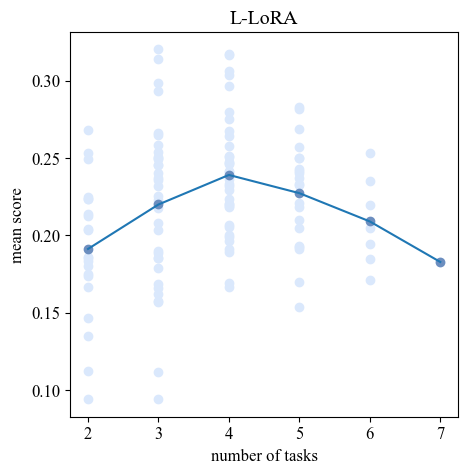

In [10]:
title = 'L-LoRA'
data = l_lora_data
# --------------
results = get_max_row_mean(data)
# for num_tasks in results:
#     print(num_tasks)
#     display(results[num_tasks])

fig, axes = plt.subplots(1,1,figsize=(5,5), squeeze=False)
ax: plt.Axes = axes[0,0]
Y_mean = []
for num_tasks in results:
    Y = np.array(results[num_tasks]['mean'])
    X = np.ones_like(Y) * num_tasks
    Y_mean.append(Y.mean())
    ax.scatter(X, Y, color = '#DAE8FC')
    ax.scatter([num_tasks], [Y.mean()], color = '#6C8EBF')
ax.plot(np.array(list(results.keys())), np.array(Y_mean))

ax.set_title(title)
ax.set_xlabel('number of tasks')
ax.set_ylabel('mean score')
plt.show()

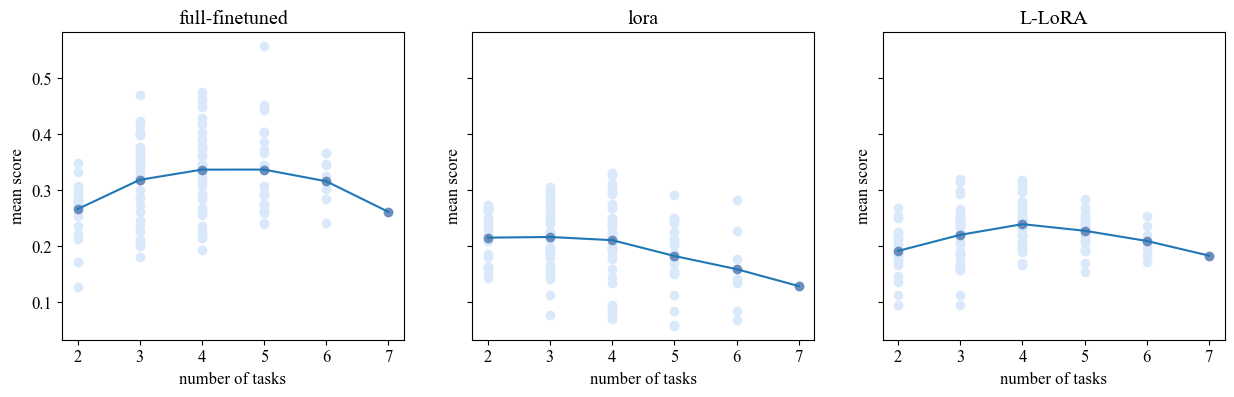

In [15]:
fig, axes = plt.subplots(1,3,figsize=(15, 4), squeeze=False, sharey=True)

title = 'full-finetuned'
data = fft_data
# --------------
results = get_max_row_mean(data)
# for num_tasks in results:
#     print(num_tasks)
#     display(results[num_tasks])

ax: plt.Axes = axes[0,0]
Y_mean = []
for num_tasks in results:
    Y = np.array(results[num_tasks]['mean'])
    X = np.ones_like(Y) * num_tasks
    Y_mean.append(Y.mean())
    ax.scatter(X, Y, color = '#DAE8FC')
    ax.scatter([num_tasks], [Y.mean()], color = '#6C8EBF')
ax.plot(np.array(list(results.keys())), np.array(Y_mean))

ax.set_title(title)
ax.set_xlabel('number of tasks')
ax.set_ylabel('mean score')


title = 'lora'
data = lora_data
# --------------
results = get_max_row_mean(data)
# for num_tasks in results:
#     print(num_tasks)
#     display(results[num_tasks])

ax: plt.Axes = axes[0,1]
Y_mean = []
for num_tasks in results:
    Y = np.array(results[num_tasks]['mean'])
    X = np.ones_like(Y) * num_tasks
    Y_mean.append(Y.mean())
    ax.scatter(X, Y, color = '#DAE8FC')
    ax.scatter([num_tasks], [Y.mean()], color = '#6C8EBF')
ax.plot(np.array(list(results.keys())), np.array(Y_mean))

ax.set_title(title)
ax.set_xlabel('number of tasks')
ax.set_ylabel('mean score')


title = 'L-LoRA'
data = l_lora_data
# --------------
results = get_max_row_mean(data)
# for num_tasks in results:
#     print(num_tasks)
#     display(results[num_tasks])

ax: plt.Axes = axes[0,2]
Y_mean = []
for num_tasks in results:
    Y = np.array(results[num_tasks]['mean'])
    X = np.ones_like(Y) * num_tasks
    Y_mean.append(Y.mean())
    ax.scatter(X, Y, color = '#DAE8FC')
    ax.scatter([num_tasks], [Y.mean()], color = '#6C8EBF')
ax.plot(np.array(list(results.keys())), np.array(Y_mean))

ax.set_title(title)
ax.set_xlabel('number of tasks')
ax.set_ylabel('mean score')
plt.show()